# RAGBRAI Guess the Route Contest

RAGBRAI (Register’s Annual Great Bicycle Ride Across Iowa) is a week-long cycling event that spans the state of Iowa from west to east, starting at the Missouri River (or the Big Sioux River if it starts north of Sioux City) and ending at the Mississippi River. [Established in 1973, it is the oldest, largest, and longest recreational bicycle touring event in the world](https://ragbrai.com/about/ragbrai-history/), drawing thousands of participants each year to experience Iowa’s small towns, scenic landscapes, and local culture. 

Each year, a contest invites participants to predict the route before it is officially announced. Winners get some merch and **bragging rights**.

This project is for data gathering and analysis to predict the next eight overnight towns for RAGBRAI.

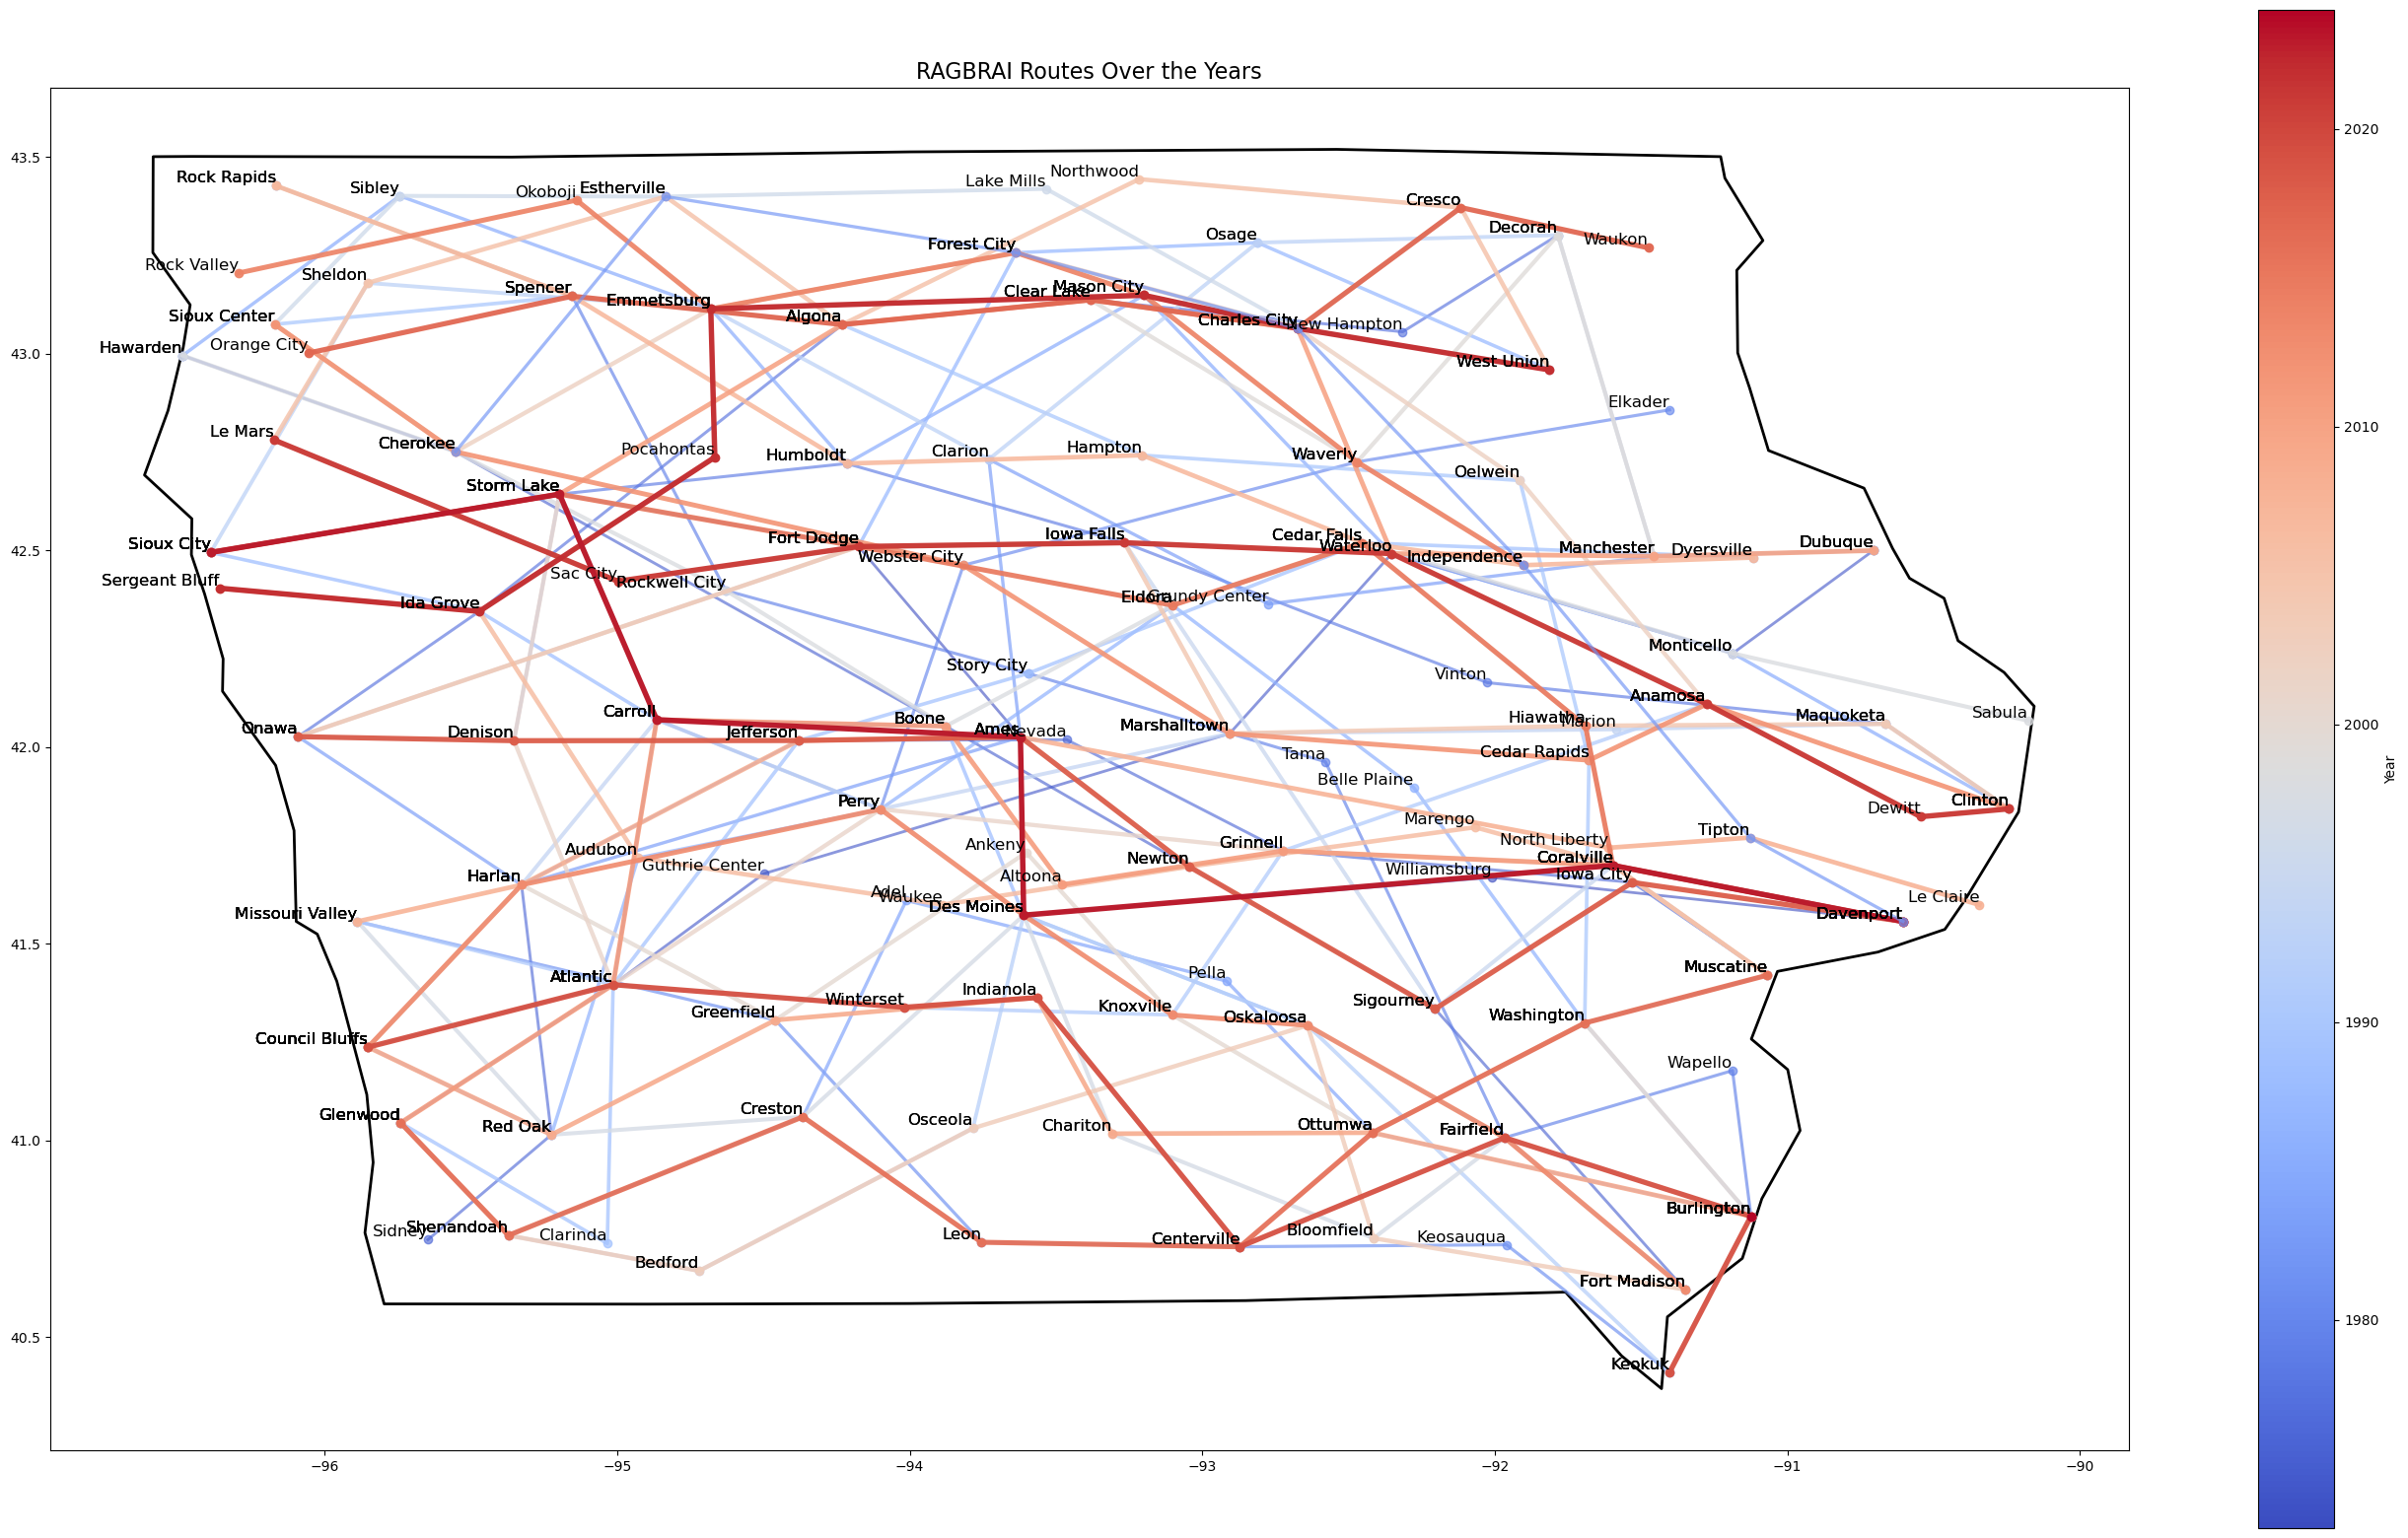

### RAGBRAI LII Details So Far

Honor Flight Network has been announces to be the Community Fund recipient for RAGBRAI LII. This might influence the route as Honor Flight has [several hubs](https://www.honorflight.org/hub-by-county/) in Iowa cities:
* Fort Dodge
* Cedar Rapids
* Waterloo
* Davenport
* Dubuque

Davenport and Dubuque are past ending town, but Davenport was visited just two years ago in 2023, so it's unlikely to be revisited so soon. That leaves Dubuque as the prime candidate.

They have also released the logo, which may or may not hint at the route with the dotted line in the background.

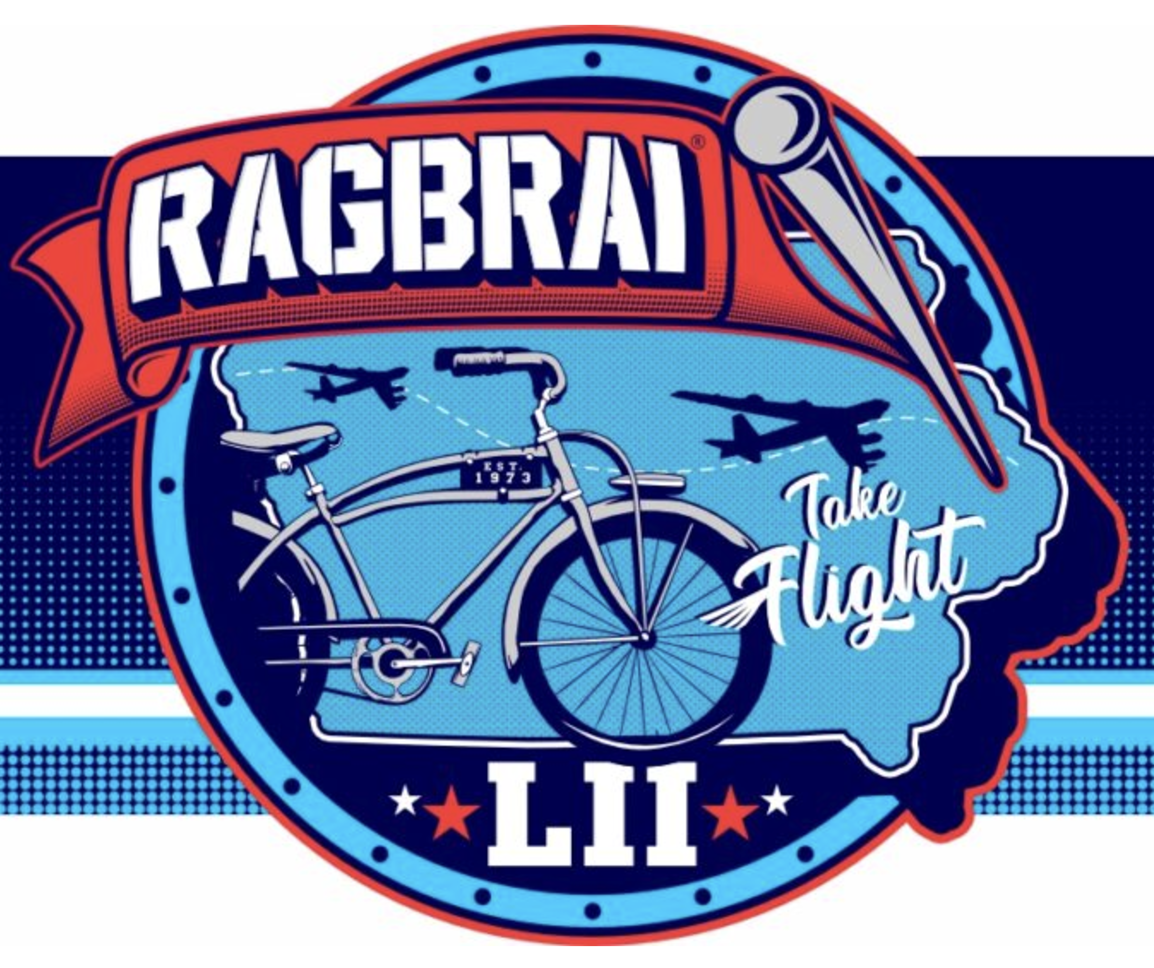

## Past Routes Analysis
A great way to predict the future is to understand the past decisions made by the route planning team. To do this, I scraped past route data from [RAGBRAI's website](https://ragbrai.com/routemaps/past-overnight-towns-grid/). 

Understanding which towns have been repeatedly visited or newly included offers valuable insights into the planning patterns for future routes.

RAGBRAI had it's 50th anniversary in 2023. Given that there is a limited pool of towns to visit, the majority of towns have already been visited, especially the start and end towns. In the last 15 years, only two of those years featured new starting towns that had not been visited before and no new ending towns were chosen. There are many more potential towns to choose from in the middle of route. For example, 30 of the towns visited on Wednesday have been unique.

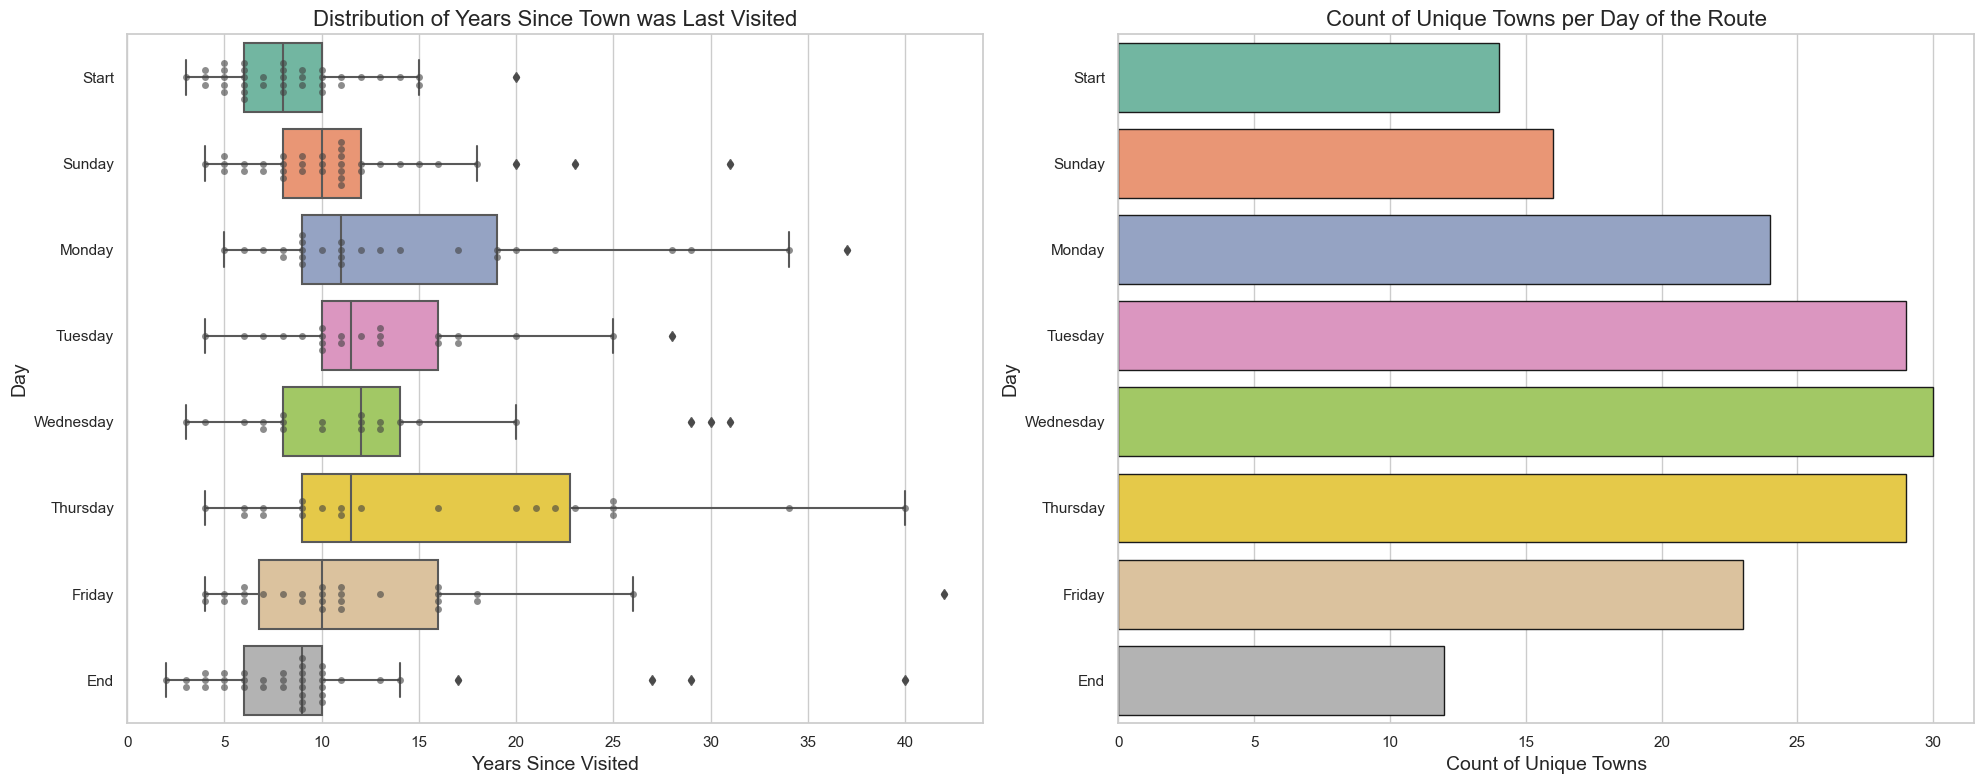

### Starting Towns
The likelihood of a town being chosen to start the route is defined by two criteria:
1. How many times has the town been used as the start in the past.
2. How many years has it been since the town was last visited.

Below is a scatterplot that shows the past 14 starting towns where we can see the number of years since the town was last visited on the x-axis and the total number of times the town has been visited on the y-axis. The median number of years since last visited is eight. 

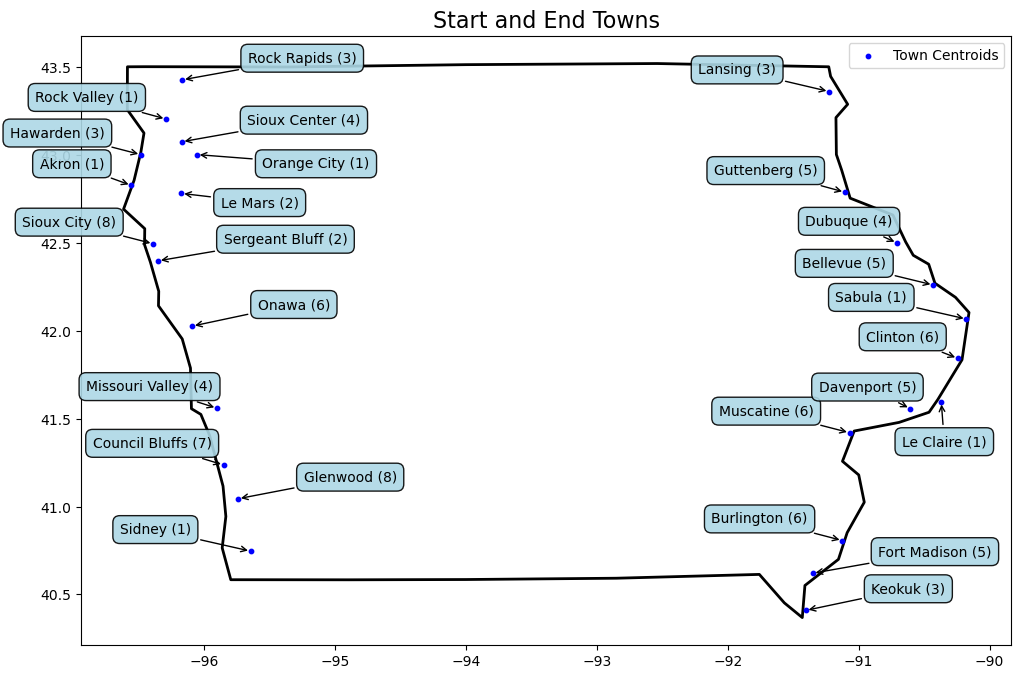

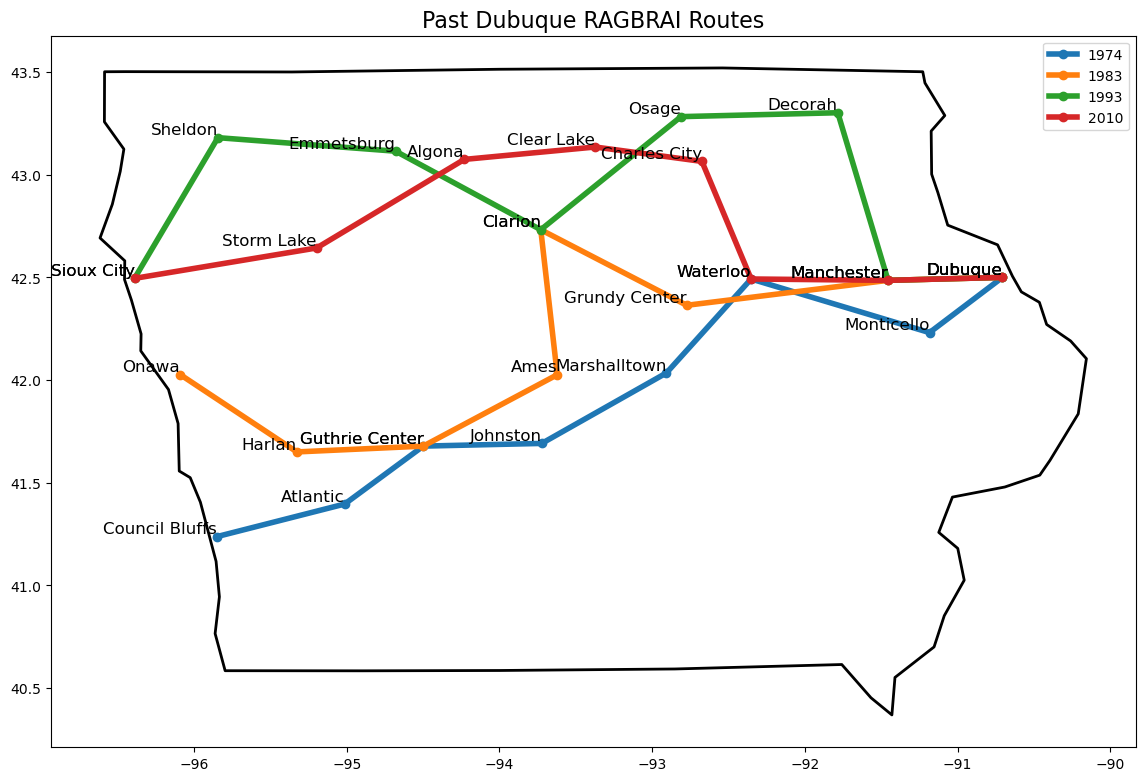

### Outlier RAGBRAI Routes
While digging into the data behind RAGBRAI routes, some routes naturally popped up as unique and warrented further investigation.

#### RAGBRAI 1973
The first ride across Iowa, finishing on a Friday instead of Saturday which made the rides significantly longer each day. Given its unique schedule and mileage, this route was excluded from the analyses to keep consistency with newer routes.

#### RAGBRAI 2019
Initially, I assumed that each day’s route would move eastward, but the 2019 route proved this wasn’t always the case. This year, RAGBRAI went to Burlington and then Keokuk, effectively backtracking 0.278 degrees west. 

Route from [desmoinesregister.com](https://www.desmoinesregister.com/story/news/2022/07/19/ragbrai-route-maps-downloadable-2022-distance-towns-parking-entertainment/10062082002/)

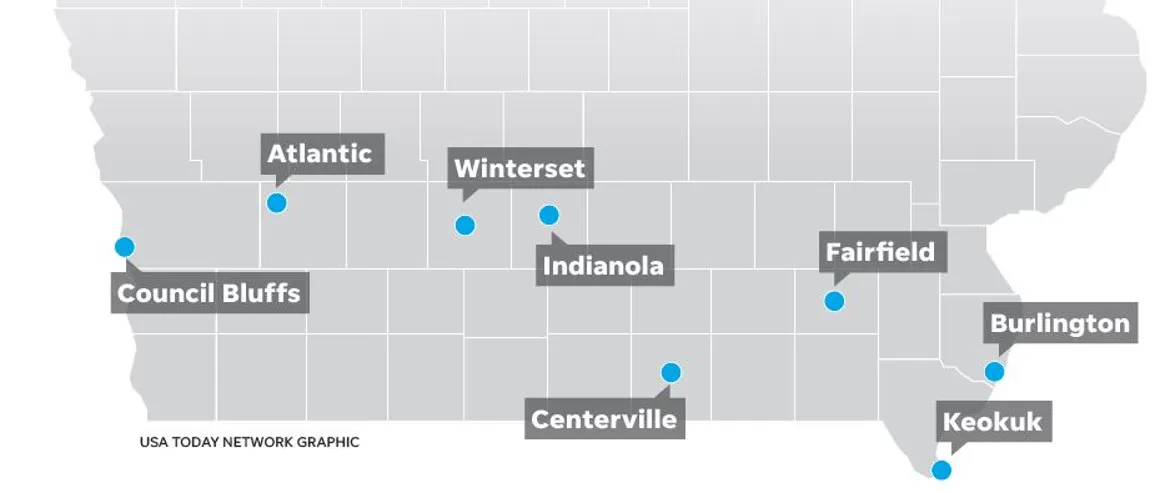

#### RAGBRAI 2022
The 2022 route included a significant 105-mile ride from Emmetsburg, as a tribute to RAGBRAI co-founder John Karras. This route also had riders backtrack from Pocahontas to Emmetsburg. 

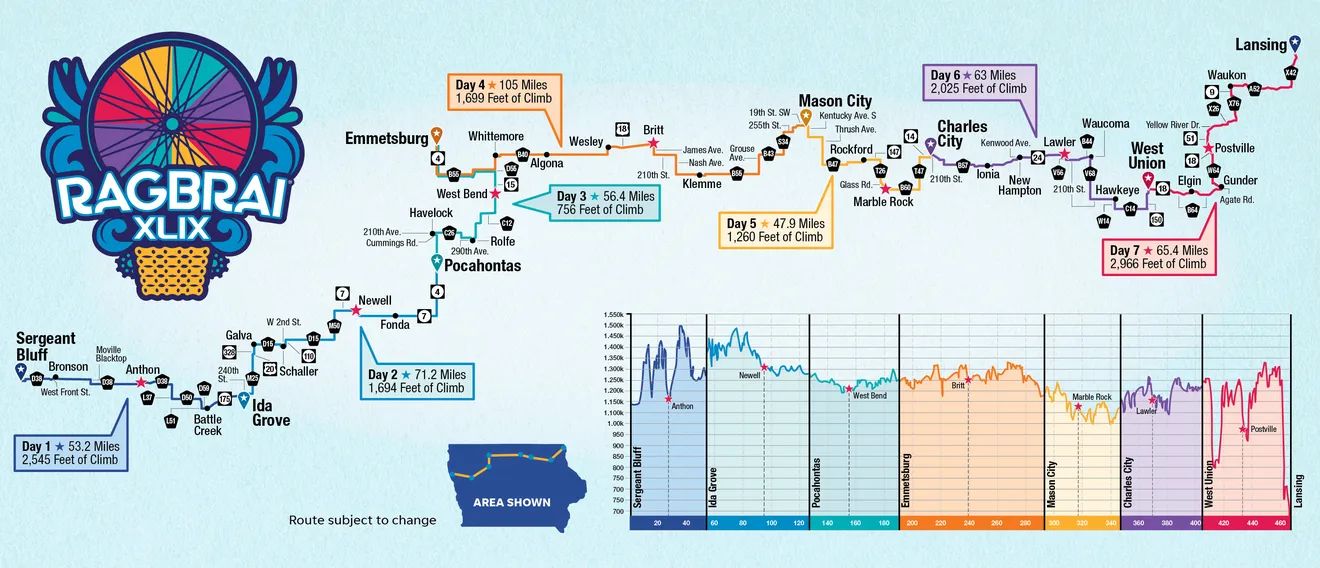

## Finding Possible Routes

### Route Requirements (Approximate)
There are no official requirements, but the [host town application](https://ragbrai.com/hosttownapplication/) does a good job of highlighting some key considerations:
- The host town must accommodate the safe movement of over 40,000 cyclists and their support crews.
- Ideally, on paved roads that have a traffic count of less than 2,500 cars per day and a truck count of less than 200.
- 60 – 70 miles between overnight towns. 
- 11 – 15 miles between pass-through towns.

### Search Constraints
- Town population must be greater than 3,000. Based on the past five years of RAGBRAI routes, I found that towns with a population of over 3,000 accounted for 87.5% of overnight stops, making this a reasonable lower bound for selecting host towns.
- Longitude requirements per day based on historic minimum and maximums.
- Longitude change must be between (-0.087, 1.594). 
- Latitude change must be between (-0.945, 0.811).
- Distance between towns must be between 15 and 85 miles. This is found using haversine distance. 


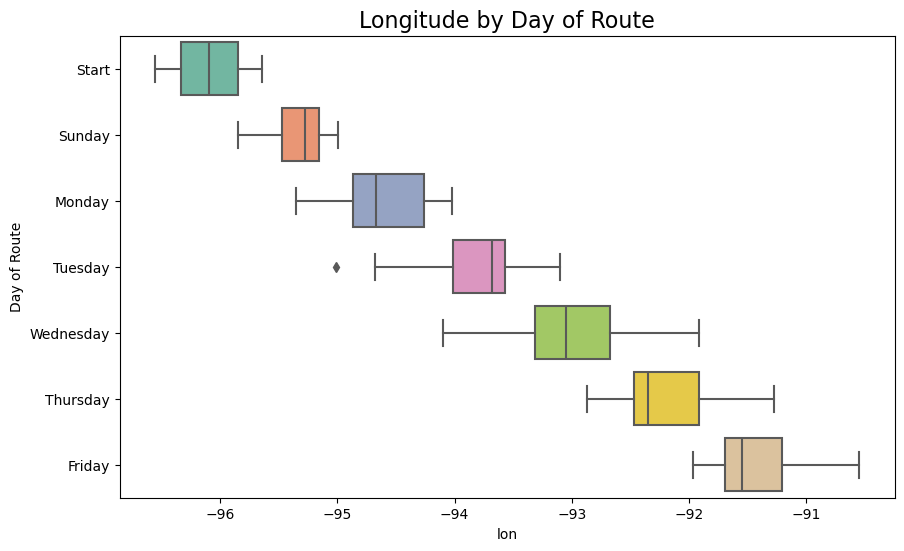

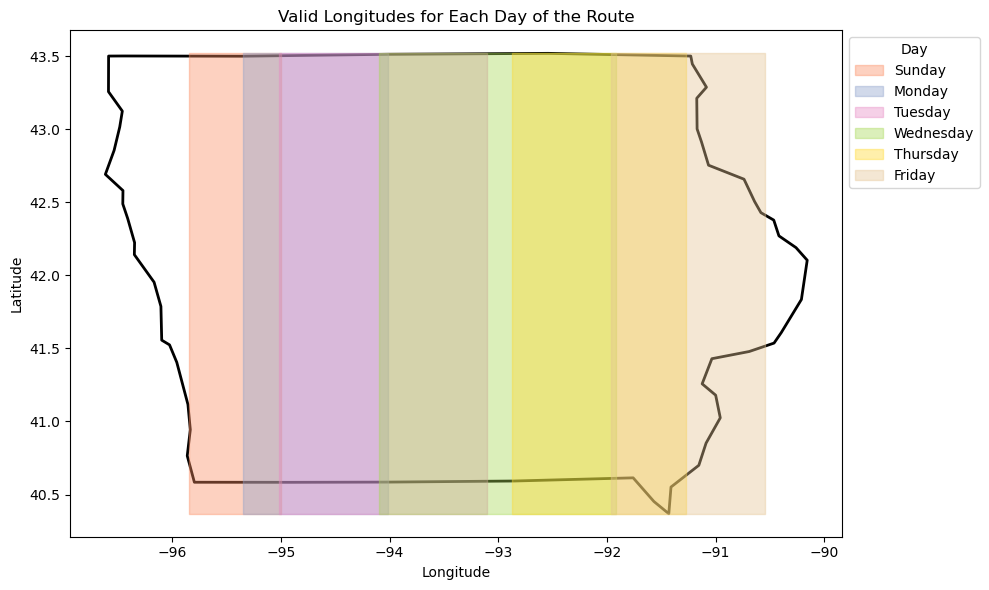

I used [IQR ranges](https://jordanbarker.github.io/notebook_library/_build/html/Notebooks/anomaly_detection.html#interquartile-range-iqr) to limit the search for towns on a given route.

* $ \text{Low Threshold} = \text{Q}1 - 1.5 * \text{IQR}$
* $ \text{High Threshold} = \text{Q}3 + 1.5 * \text{IQR}$

For example, longitude change was constrained between -0.087 and 1.594. Ames IA has a longitude of -93.61 so Marshalltown is within reach (-92.94), but Cedar Rapids is not (-91.74).

For instance, Ames, with a longitude of -93.61, can realistically connect to Marshalltown (-92.94) under the defined range, but Cedar Rapids (-91.74) falls outside these constraints.

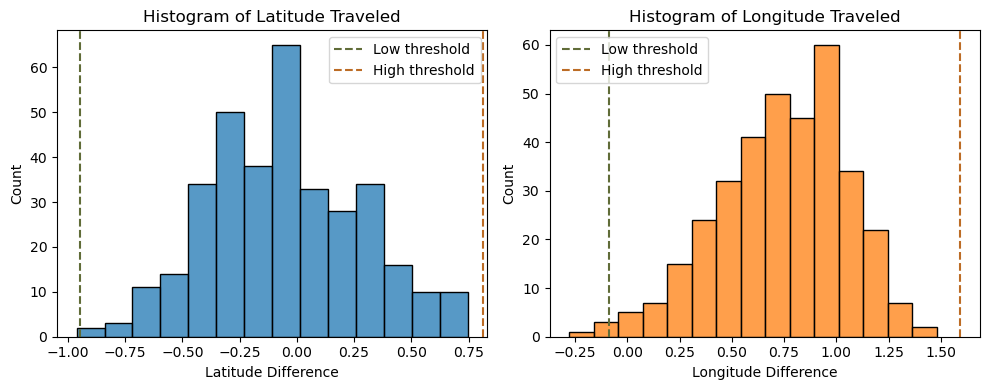

### Scoring and Ranking Routes

To narrow down the list of possible routes, I created a scoring system that balances the frequency of a town’s past visits with the time elapsed since its last inclusion. The logic is simple: towns frequently chosen as stops are more likely to appear again, while towns not visited for many years have a higher chance of reappearing. This system naturally excludes towns visited in the previous year (score of zero) and gives less importance towns that were rarely visited, even if they were visited long ago.

The score for a town on a given day is calculated as the product of two factors: (1) the town’s total visit count raised to the power of 1.5 to give more weight to frequently visited towns, and (2) the number of years since its last visit. This weighting ensures that both frequency and recency are accounted for in predicting its likelihood of being chosen.

Town scores are calculated using the formula:

$$ \text{Town Score}_{\text{ (Day)}} = \text{Visit Count}^{1.5} \cdot \text{Years Since Last Visit} $$

Here, $\text{Visit Count}$ refers to the number of times a town has hosted an overnight stop, and $\text{Years Since Last Visit}$ indicates how long it has been since the town was last part of the route.

The scatterplot below visualizes how towns are scored based.  
* The left plot shows how scores change with visit frequency and recency.
* The right plot visualizes how these scores play out look on real towns.

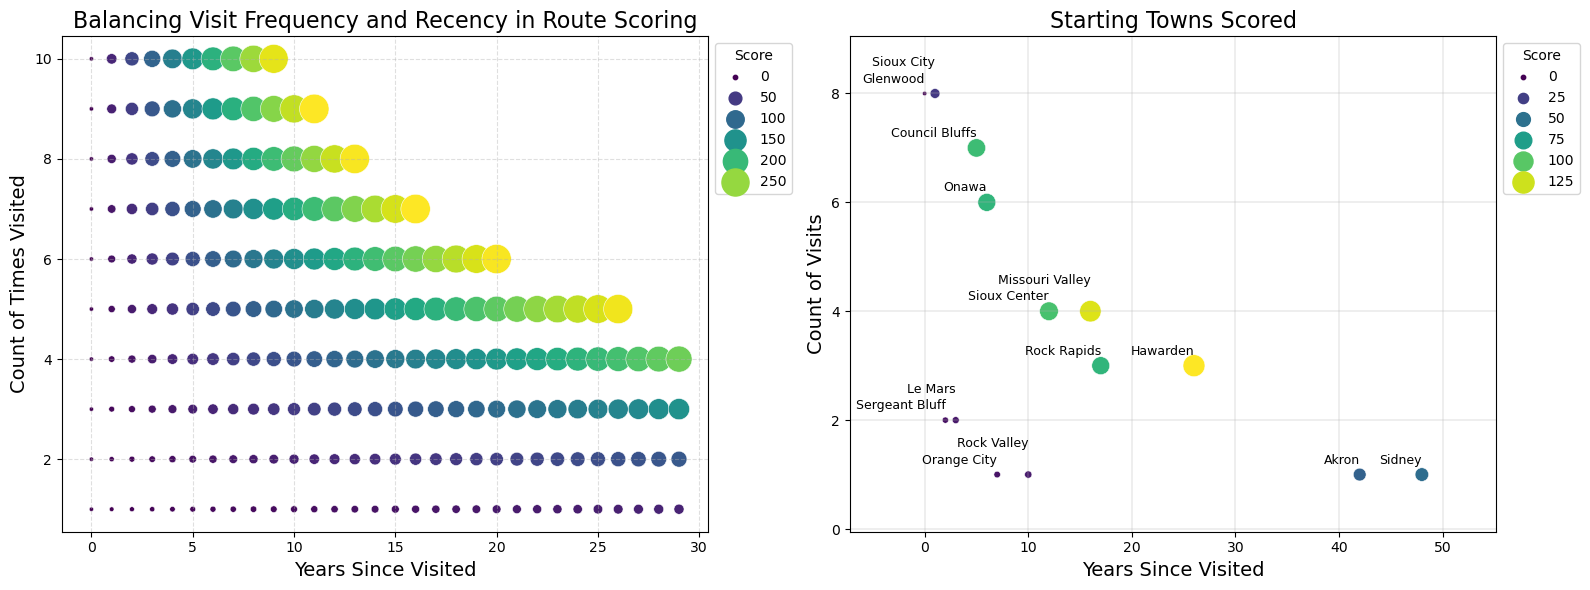

The total route score, calculated as the sum of town scores across all seven days, helps prioritize routes that align with historical patterns while accommodating RAGBRAI’s preference for variety.

$$ \text{Route Score} = \sum_{\text{Day}=1}^{7} \text{Town Score}_{\text{ (Day)}} $$

By scoring and summing up towns in this way, I can effectively rank potential routes based on their alignment with historical trends and likelihood of selection.

## Appendix

* Nodes: These are points on the map such as towns or road intersections.
* Edges: These are the connections between nodes, representing the road segments. Each edge contains additional metadata, such as road type, length, travel time, and other attributes sourced from OpenStreetMap.

### Custom Path Weights
Not all roads are equal when planning a RAGBRAI route. To account for this, I added custom weights to the edges in my graph. 

Roads are classified by their [highway type](https://wiki.openstreetmap.org/wiki/Key:highway), and I assigned the following penalties to discourage paths on busier roads:

| Highway Type | Penalty |
| -------- | ------- |
| primary  | 20x    |
| trunk | 15x     |
| motorway    | 12x    |
| primary_link    | 10x    |
| trunk_link    | 10x    |
| motorway_link    | 10x    |

### Paths Between Towns
Finding the path between overnight towns is a computationally expensive task. To reduce the number of possible paths to explore, I narrowed down the list of towns based on some heuristics gathered from past routes. 

For example starting in Sioux Center, we would narrow down the list of towns to those which are within historic limits of latitude and longitude traveled in a day as well as the haversine distance between the center of the towns. This gets us a list of 20 candidate towns. We can then calculate a path from Sioux Center to each candidate town to see if the path is greater than 35 miles and less than 85 miles. 

The map below demonstrates the two-stage filtering example. Each town shown has made it past the first round of filtering. Green lines represent valid paths. Orange lines represent the path to towns that turned out to be too short or too far.

This filtering can be modified to make the rules more or less strict. I tried to strike a balance between getting almost all possible paths while not trying to capture anomolies like 2019. 


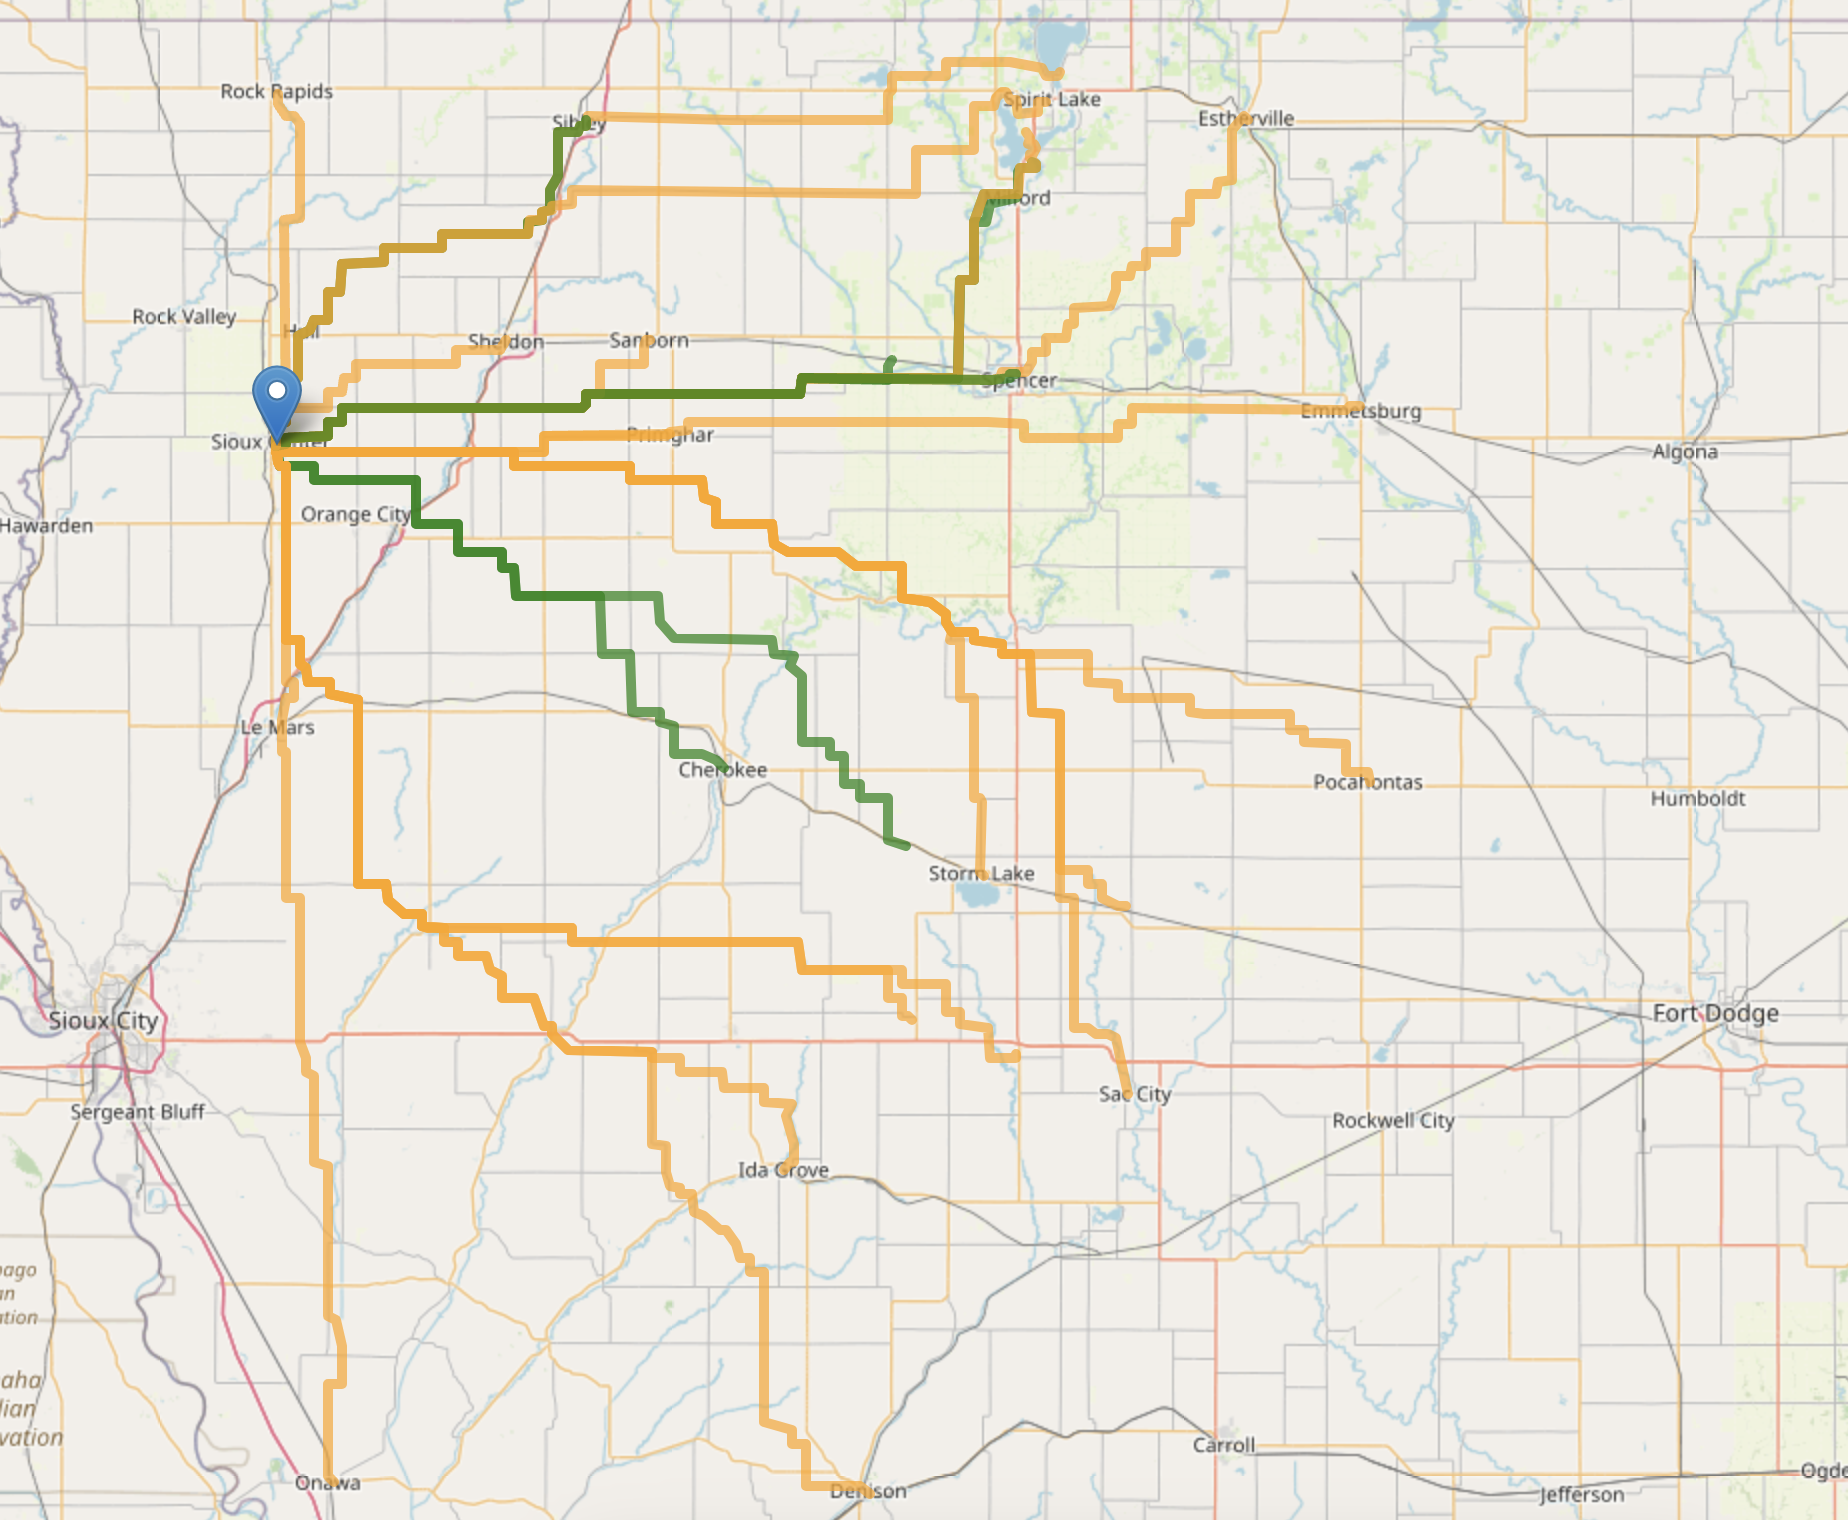

### Computational Challenges and Pivot

I kicked off the program and let it run overnight to find all possible routes with the starting point of Sioux Center. After a full day of running, I only had routes for the first few days. The issue was a combinatorial explosion in possible routes.

After a several iterations of code optimization, it was still taking way too long to run. I estimated it would take over a year to finish at this rate. Below is an image of the 30k routes generated and I only made it to Tuesday.

So I pivoted. I didn't really care to find all possible routes, but rather the most likely ones. To find those, I increased the route requirements significantly. This way, I still capture the majority of routes, and I can more readily interpret the results. 

## Data and Tools
Huge thank you to the following resource providers for making this project possible:

* [Natural Earth](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-1-states-provinces/) has boundary files for Iowa available to download for free. 
* [OSMnx](https://osmnx.readthedocs.io/en/stable/) offers a great interface for pulling map data from OpenStreetMap. One line of code was all it takes to get the roads and cities in Iowa saved as a graph form: `G = ox.graph_from_place("Iowa", network_type="drive")`. Note: this took a **long** time. I saved it to my project directory so I only had to do it once, but the file size was too large for github (about 325 MB). 
* The Python package [wptools](https://pypi.org/project/wptools/) made pulling wikipedia information automatically. I pulled the population information and county for each town in the dataset. 